# GSEAPY Example

### Examples to walk through ``GSEApy``

## 1.  Load essential packages

In [1]:
%matplotlib inline
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

** Check gseapy version **

In [2]:
gp.__version__

'0.8.7'

### See all gseapy supported enrichr library names 

Enrichr library could be used for ``gsea``, ``ssgsea``, and ``prerank``, too

In [3]:
names = gp.get_library_name()
names[:10]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_down']

## 2. Enrichr Example

### 1)  Assign enrichr with ``pd.Series``,  ``pd.DataFrame``, or ``list`` object

In [4]:
gene_list = pd.read_table("./gene_list.txt",header=None)
gene_list.head()

,0
0,CTLA2B
1,SCARA3
2,LOC100044683
3,CMBL
4,CLIC6


In [5]:
type(gene_list)

pandas.core.frame.DataFrame

In [6]:
# convert dataframe or series to list
glist = gene_list.squeeze().tolist()
print(glist[:10])

['CTLA2B', 'SCARA3', 'LOC100044683', 'CMBL', 'CLIC6', 'IL13RA1', 'TACSTD2', 'DKKL1', 'CSF1', 'CITED1']


In [7]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list="./gene_list.txt", 
                 # or gene_list='./gene_list.txt', or gene_list=glist
                 description='test_name', 
                 gene_sets='KEGG_2016', 
                 outdir='enrichr_kegg', 
                 cutoff=0.5 # test dataset, use lower value of range(0,1)
                )


In [8]:
enr.res2d.head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes
0,Rap1 signaling pathway_Homo sapiens_hsa04015,19/211,0.000148,0.035223,0.000436,0.103734,-1.961363,17.295956,PDGFRB;CSF1;FLT4;VEGFC;ARAP3;LPAR4;ADCY7;ADCY6...
1,Pathways in cancer_Homo sapiens_hsa05200,27/397,0.000729,0.066282,0.001816,0.152127,-2.083086,15.046848,RET;LEF1;TGFA;LPAR4;ADCY7;ETS1;ADCY6;GLI2;FGF4...
2,Ras signaling pathway_Homo sapiens_hsa04014,18/227,0.000999,0.066282,0.002351,0.152127,-1.956845,13.519663,PDGFRB;CSF1;FLT4;VEGFC;ETS1;GNG13;FGF4;PLD2;EF...
3,Dilated cardiomyopathy_Homo sapiens_hsa05414,10/90,0.001114,0.066282,0.002557,0.152127,-1.805957,12.280169,DES;SGCB;TPM2;TNNC1;LMNA;TPM1;ITGAV;ADCY7;ADCY...
4,HTLV-I infection_Homo sapiens_hsa05166,19/258,0.001747,0.083151,0.003877,0.184562,-1.843079,11.703417,PDGFRB;STAT5B;EGR1;JUN;CD40;FZD2;CRTC3;NFATC1;...


### 2) Command line usage 

You may also want to use enrichr in command line  

the option **-v** will print out the progress of your job

In [9]:
!gseapy enrichr -i ./gene_list.txt \
               --description BP2017 \
               -g GO_Biological_Process_2017 \
               -v -o enrichr_BP

2017-11-24 13:04:41,536 Connecting to Enrichr Server to get latest library names
2017-11-24 13:04:42,380 Analysis name: BP2017, Enrichr Library: GO_Biological_Process_2017
2017-11-24 13:04:44,967 Submitted gene list:{'shortId': '350ch', 'userListId': 6127543}
2017-11-24 13:04:51,766 Downloading file of enrichment results: Job Id:{'shortId': '350ch', 'userListId': 6127543}
2017-11-24 13:04:55,500 Warning: No enrich terms using library GO_Biological_Process_2017 when cuttoff = 0.05
2017-11-24 13:04:55,500 Done.



## 3. Prerank example

### 1) Assign prerank()  with a pd.DataFrame, pd.Series , or a txt file
Do not include header !  
GSEApy will skip any comment lines startswith "#".  
Only contains two columns, or one cloumn with gene_name indexed when assign a ``DataFrame`` to prerank

In [10]:
rank = pd.read_table("./edb/gsea_data.gsea_data.rnk", header=None)
rank.head()

,0,1
0,CTLA2B,2.502482
1,SCARA3,2.095578
2,LOC100044683,1.116398
3,CMBL,0.877640
4,CLIC6,0.822181


In [11]:
# run prerank
# enrichr libraries are supported by prerank module. Just provide the name
pre=[]
for s, n in zip(['./genes.gmt', 'KEGG_2016'],['bp','kegg']):
    #use 4 process to acceralate the permutation speed
    pre_res = gp.prerank(rnk=rank, 
                         gene_sets=s, 
                         processes=4,
                         permutation_num=100, # reduce number to speed up test
                         outdir='prerank_report_'+n,format='png')
    pre.append(pre_res)

In [12]:
#access results through res2d attribute
pre[0].res2d.head()

,es,nes,pval,fdr,gene_set_size,matched_size,genes
Term,,,,,,,
DvA_UpIN_A,0.405880,1.668479,0.042857,0.091603,284,19,"ABHD14B,VNN1,NELF,MARVELD2,LAMB3,TMPRSS2,TM6SF..."
DvA_UpIN_D,0.166924,0.681628,0.819672,0.809160,236,21,"PMP22,STBD1,DUSP14,RET,GPX8,CHRNB1,PRKD1,COL7A..."


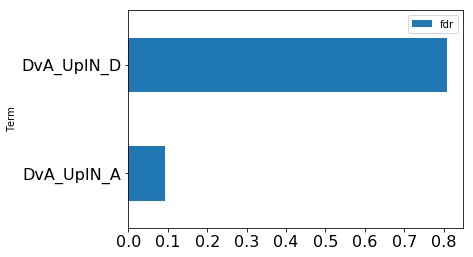

In [13]:
pre_res = pre[0]
prerank_results = pre_res.res2d
prerank_results = prerank_results.reset_index()
prerank_results.head(5).plot.barh(y='fdr',x='Term',fontsize=16)

### 2) Command line usage 

You may also want to use prerank in command line

In [14]:
# ! gseapy prerank -r temp.rnk -g temp.gmt -o prerank_report_temp

## 4. GSEA Example

### 1)  Assign gsea() with a pandas DataFrame, .gct format file, or a text file

and cls with a list object or just .cls format file 

In [15]:
phenoA, phenoB, class_vector =  gp.parser.gsea_cls_parser("./P53.cls")

In [16]:
#class_vector used to indicate group attributes for each sample
print(class_vector)

['MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT']


In [17]:
gene_exp = pd.read_table("./P53_resampling_data.txt")
gene_exp.head()

,NAME,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
0,CTLA2B,111.19,86.22,121.85,75.19,208.62,130.59,124.72,324.09,242.71,...,163.76,59.50,134.12,152.09,197.46,137.79,81.53,123.37,81.41,180.78
1,SCARA3,460.30,558.34,183.55,37.29,158.00,43.61,80.83,300.08,1250.25,...,109.91,120.42,73.06,115.03,95.12,37.56,76.16,41.10,77.51,519.17
2,LOC100044683,97.25,118.94,81.17,119.51,119.88,107.73,165.57,203.97,135.43,...,222.84,124.98,114.75,141.66,170.19,147.70,157.48,152.18,98.89,118.06
3,CMBL,33.45,55.10,221.67,50.30,35.12,75.70,84.01,44.12,79.96,...,51.32,117.11,59.46,78.46,45.55,49.07,96.69,33.09,10.38,52.89
4,CLIC6,35.75,41.26,63.04,219.86,42.53,54.19,86.98,71.20,53.89,...,154.05,31.62,37.66,32.64,63.35,27.95,70.99,36.25,17.50,49.41


In [18]:
print("positively correlated: ", phenoA)

positively correlated:  MUT


In [19]:
print("negtively correlated: ", phenoB)

negtively correlated:  WT


In [20]:
# run gsea
# enrichr libraries are supported by gsea module. Just provide the name

gs_res = gp.gsea(data=gene_exp, # or data='./P53_resampling_data.txt'
                 gene_sets='KEGG_2016', # enrichr library names
                 cls=class_vector, # or cls= './P53.cls'
                 #set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype', 
                 permutation_num=100, # reduce number to speed up test
                 outdir='gsea_reprot', 
                 method='signal_to_noise', 
                 format='png')

In [21]:
#access the dataframe results throught res2d attribute
gs_res.res2d.head()

,es,nes,pval,fdr,gene_set_size,matched_size,genes
Term,,,,,,,
DvA_UpIN_A,-0.524014,-1.712877,0.022727,0.011111,284,19,"NELF,TMPRSS2,TSPAN33,JAK2,MAP3K5,VNN1,SELENBP1..."
DvA_UpIN_D,0.188121,0.621777,0.944444,0.936364,236,21,"GPX8,GAP43,SPEG,GNB4,PMP22,PROCR,RET,KLHL5,DUS..."


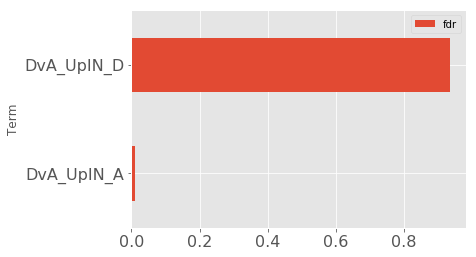

In [22]:
gsea_results= gs_res.res2d
with plt.style.context('ggplot'):
    gsea_results = gsea_results.reset_index()
    gsea_results.head(5).plot.barh(y='fdr',x='Term',fontsize=16)

### 2) Show the gsea plots

The **gsea** module will generate heatmap for genes in each gene sets in the backgroud.

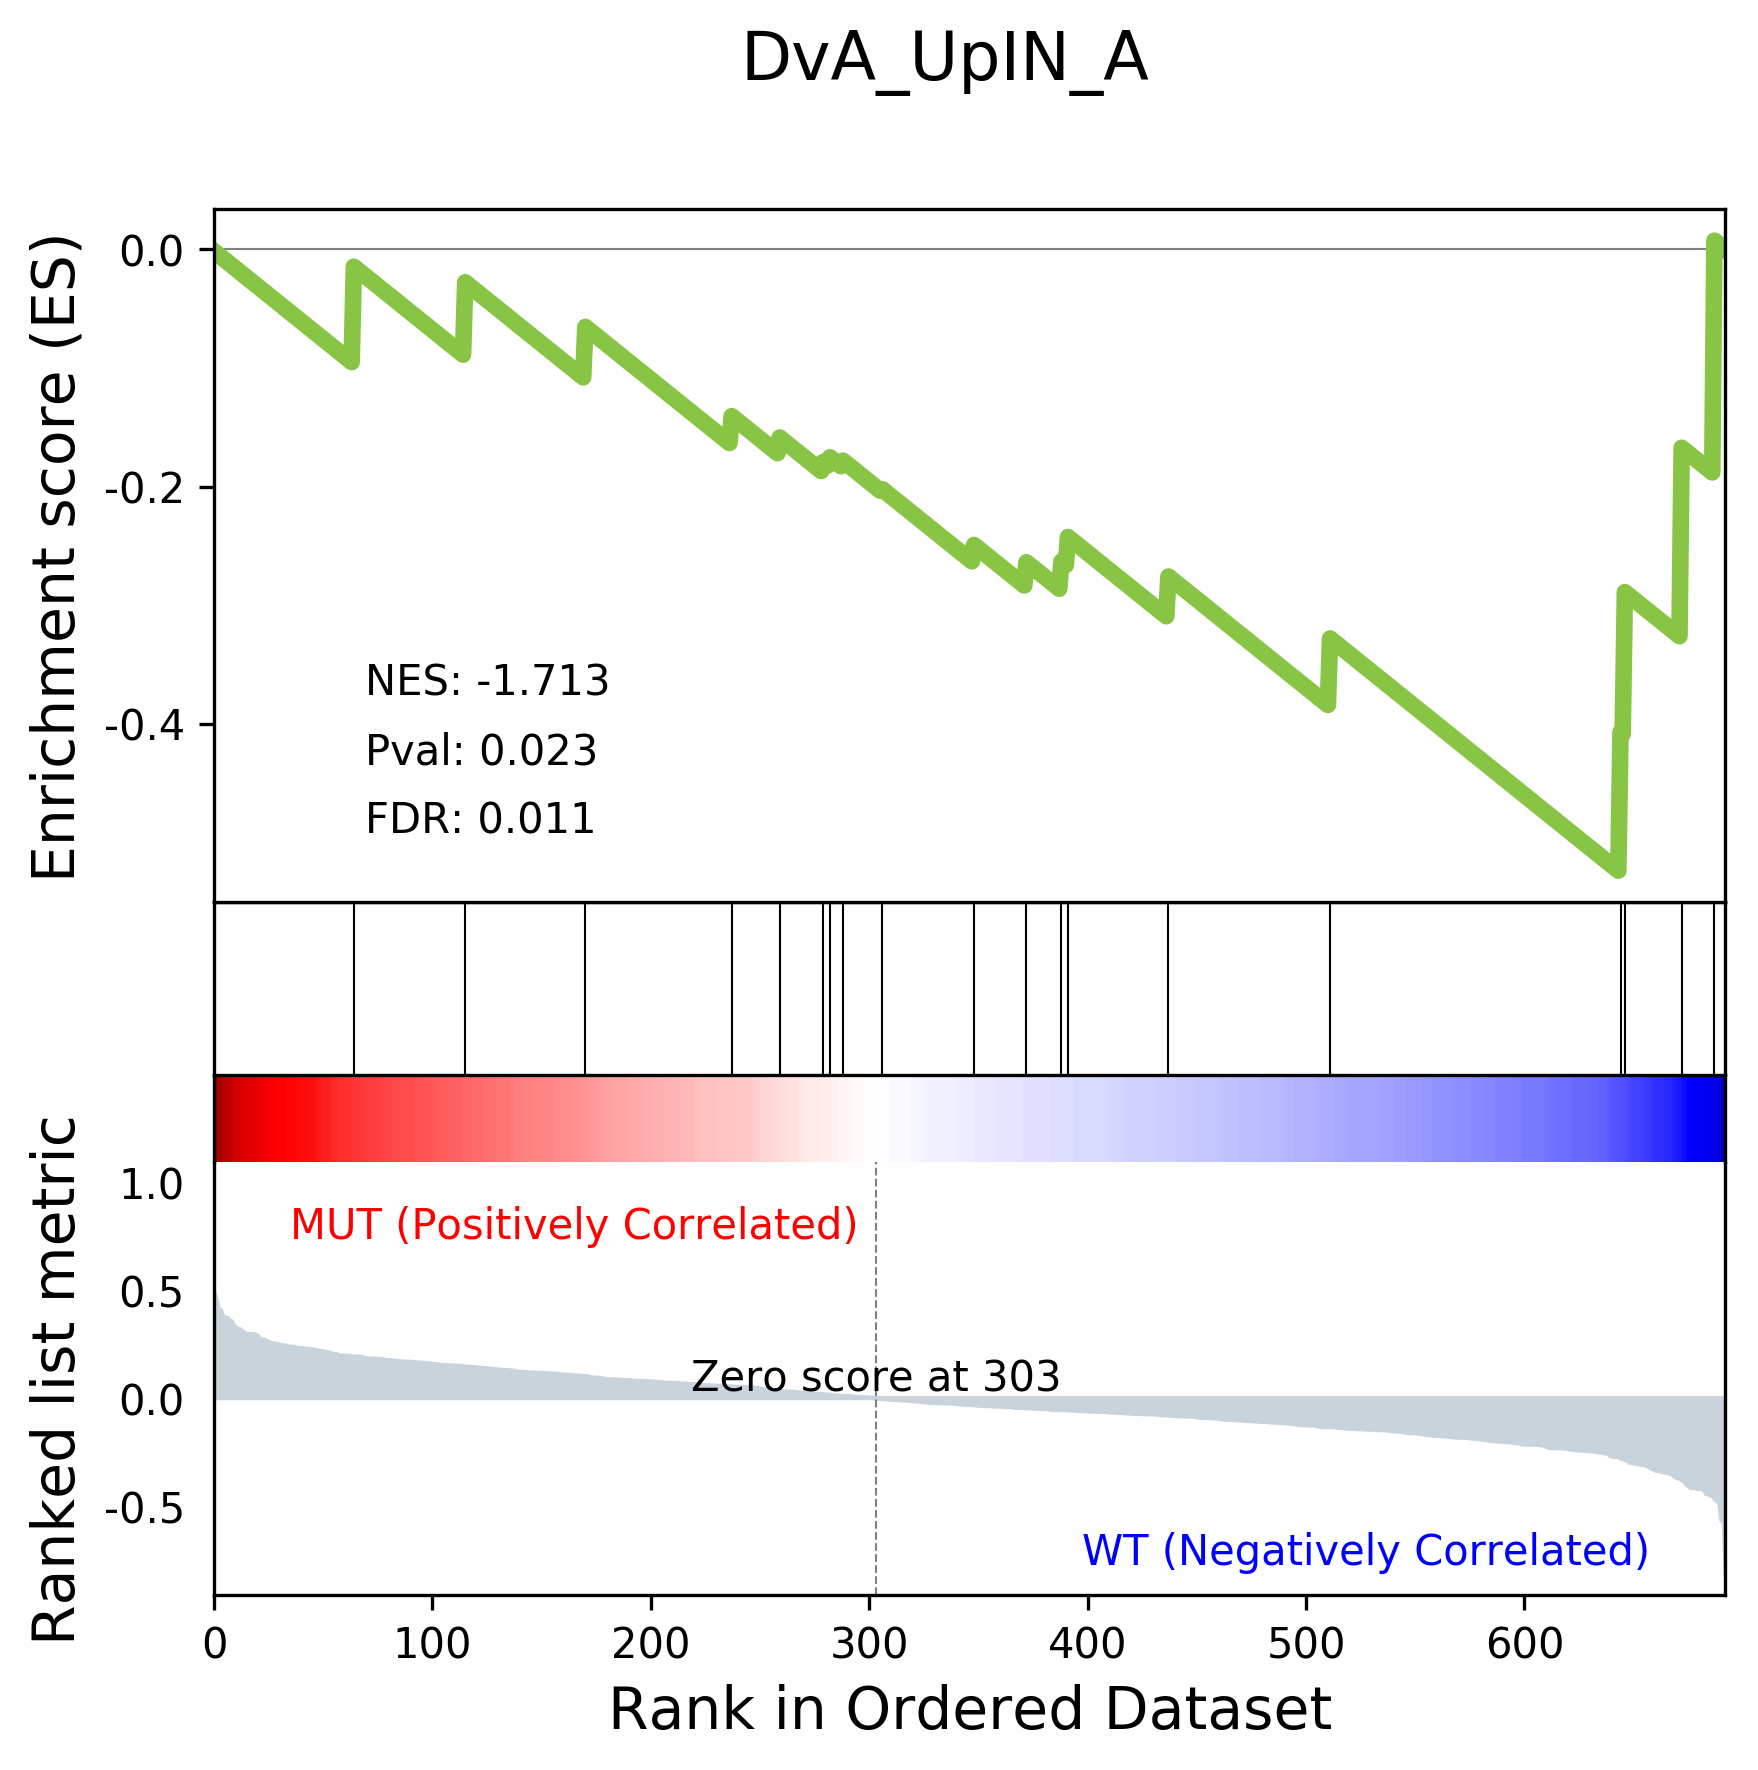

In [37]:
from IPython.display import Image

#erich plot
Image("./gsea_reprot/DvA_UpIN_A.gsea.png",width=650, height=600)

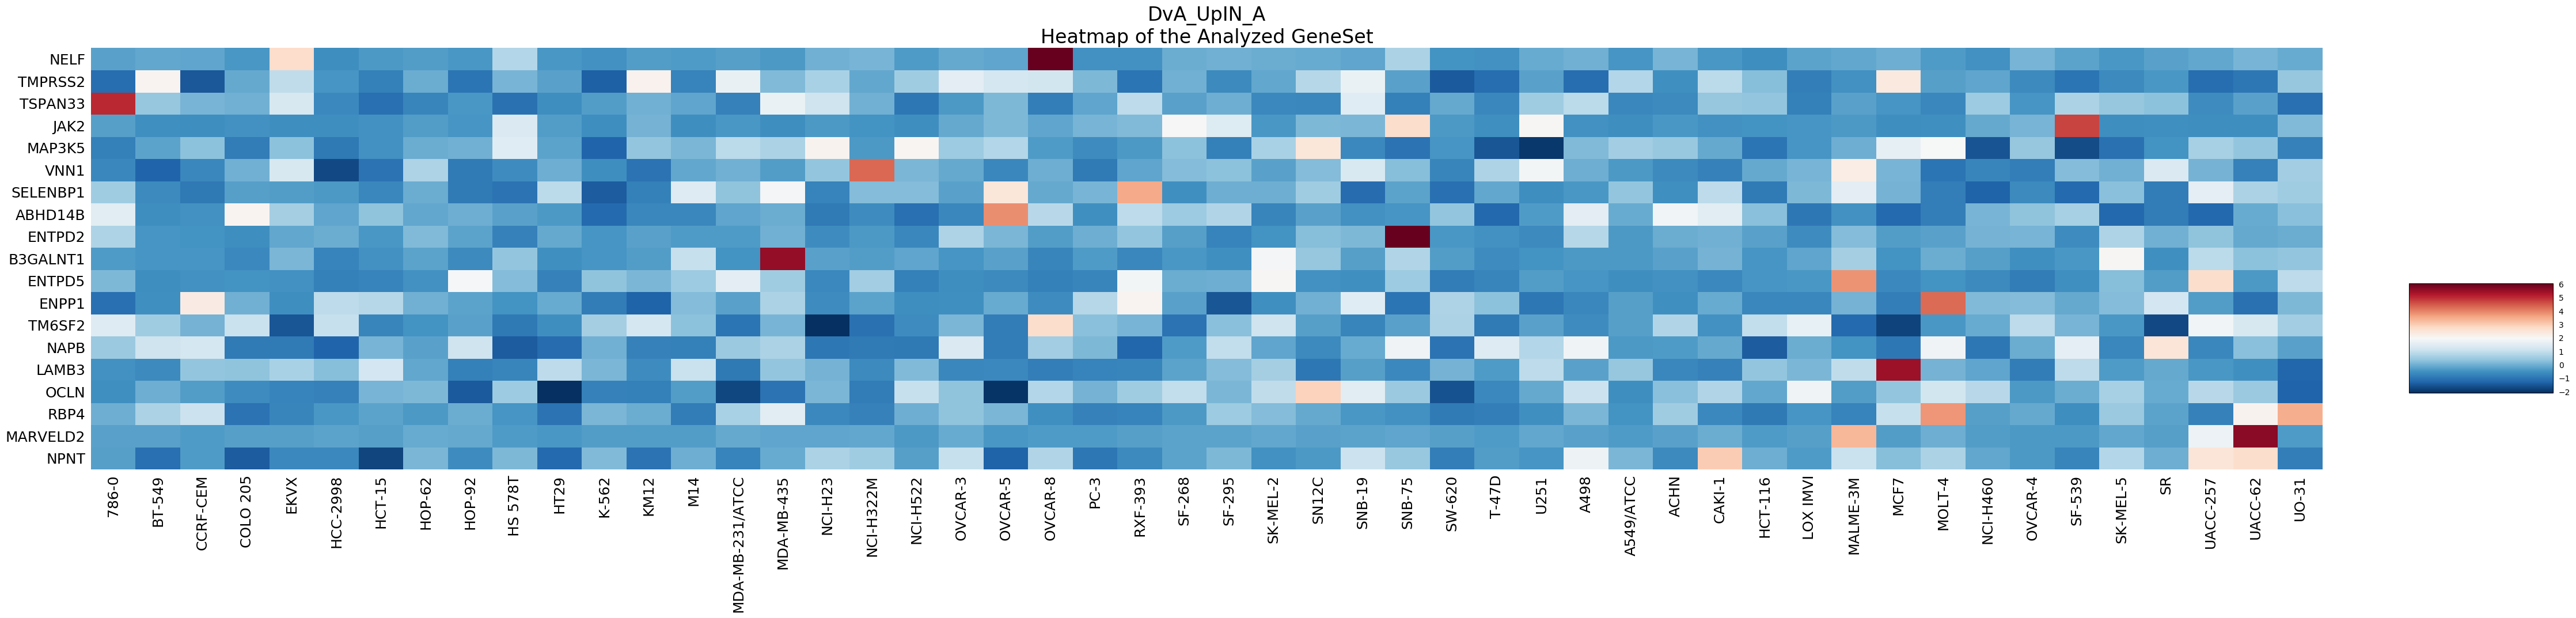

In [38]:
#corresponding heatmap
Image("./gsea_reprot/DvA_UpIN_A.heatmap.png")

### 3) Command line usage 

You may also want to use gsea in command line

In [25]:
# !gseapy gsea -d ./P53_resampling_data.txt -g KEGG_2016 -c ./P53.cls -o gsea_reprot_2 -v -t phenotype

## 5. Single Sample GSEA example

**Note: When you run ssGSEA, all genes names in your gene_sets file should be found in your expression table**

### 1) Assign ssgsea() with a txt file, dataframe, or Seires(gene name as index).  


In [26]:
# txt file input
ss = gp.ssgsea(data="./testSet_rand1200.gct",
               gene_sets="./randomSets.gmt", 
               outdir='ssgsea_report', 
               sample_norm_method='rank', # choose 'custom' for your own rank list 
               permutation_num=100, # reduce number to speed up test
               processes=4, format='png')

In [27]:
# or assign a dataframe, or Series to ssgsea()
ssdf = pd.read_table("./temp.txt",header=None)
ssdf.head()

,0,1
0,ATXN1,16.456753
1,UBQLN4,13.989493
2,CALM1,13.745533
3,DLG4,12.796588
4,MRE11A,12.787631


In [28]:
# dataframe with one column is also supported by ssGSEA or Prerank
# But you have to set gene_names as index
ssdf2 = ssdf.set_index(0)
ssdf2.head()

,1
0,
ATXN1,16.456753
UBQLN4,13.989493
CALM1,13.745533
DLG4,12.796588
MRE11A,12.787631


In [29]:
type(ssdf2)

pandas.core.frame.DataFrame

In [30]:
ssSeries = ssdf2.squeeze()
type(ssSeries)

pandas.core.series.Series

In [31]:
#Series Example
# supports dataframe and series
for dat in [ssdf, ssdf2, ssSeries]:
    ss = gp.ssgsea(data=ssdf, 
                   gene_sets="./temp.gmt", 
                   outdir='ssgsea_report_series',
                   permutation_num=100, # reduce number to speed up test
                   processes=4, format='png')

In [32]:
ss.res2d.head(5)

,es,nes,pval,fdr,gene_set_size,matched_size,genes
Term,,,,,,,
hsa05205,0.341007,19.560692,0.0,0.0,203,201,"CTNNB1,PRKACA,GRB2,EGFR,RAC1,PRKCA,KRAS,CD44,M..."
hsa05412,0.290588,10.006264,0.0,0.0,74,74,"CTNNB1,ACTB,ITGB1,CACNG3,RYR2,CTNNA1,CACNA2D3,..."
hsa05410,0.270626,9.529653,0.0,0.0,83,83,"ACTB,ITGB1,TPM3,CACNG3,RYR2,CACNA2D3,ITGAV,ITG..."
hsa05323,0.166596,5.875864,0.0,0.0,89,89,"JUN,ITGB2,ATP6V1B2,ATP6V1E1,IL1A,TGFB1,TEK,ATP..."
hsa05322,0.176818,7.420074,0.0,0.0,134,134,"GRIN2B,H2AFX,ACTN1,HIST4H4,SNRPD1,C3,GRIN2A,SS..."


### 2) `ssgsea` supports gene expression matix in gct format.  

if gene expression matrix is provided, ssgsea works like pandas apply(),  
which means it will compute NES,FDR ... for every sample pairwise.  
finally, you can assces the reuslts through **resultsOnSamples** attribute.  

Take previous gene_exp dataframe for example

In [33]:
df = pd.read_table("./P53_resampling_data.txt")
df.head()

,NAME,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
0,CTLA2B,111.19,86.22,121.85,75.19,208.62,130.59,124.72,324.09,242.71,...,163.76,59.50,134.12,152.09,197.46,137.79,81.53,123.37,81.41,180.78
1,SCARA3,460.30,558.34,183.55,37.29,158.00,43.61,80.83,300.08,1250.25,...,109.91,120.42,73.06,115.03,95.12,37.56,76.16,41.10,77.51,519.17
2,LOC100044683,97.25,118.94,81.17,119.51,119.88,107.73,165.57,203.97,135.43,...,222.84,124.98,114.75,141.66,170.19,147.70,157.48,152.18,98.89,118.06
3,CMBL,33.45,55.10,221.67,50.30,35.12,75.70,84.01,44.12,79.96,...,51.32,117.11,59.46,78.46,45.55,49.07,96.69,33.09,10.38,52.89
4,CLIC6,35.75,41.26,63.04,219.86,42.53,54.19,86.98,71.20,53.89,...,154.05,31.62,37.66,32.64,63.35,27.95,70.99,36.25,17.50,49.41


In [34]:
# dataframe support for multisamples 
ss = gp.ssgsea(data=df, 
               gene_sets="edb/gene_sets.gmt", 
               outdir='ssgsea_df_test', 
               permutation_num=100, # reduce number to speed up test
               processes=4, format='png')

Results for all samples are saves to a dataframe,  
you can assces the reuslts through resultsOnSamples attribute.  

In [35]:
# es results for all samples are saves to dict.
# convert to dataframe 
ss2 = pd.DataFrame(ss.resultsOnSamples)
ss2.head()

,786-0,A498,A549/ATCC,ACHN,BT-549,CAKI-1,CCRF-CEM,COLO 205,EKVX,HCC-2998,...,SN12C,SNB-19,SNB-75,SR,SW-620,T-47D,U251,UACC-257,UACC-62,UO-31
CDX2 OE-SPECIFIC,0.029866,0.009337,0.009991,-0.006401,0.021200,0.004605,0.040562,-0.000645,-0.038442,0.034446,...,0.004149,0.070998,0.013445,0.024796,0.040438,0.020149,0.046420,0.068213,0.074007,0.004254
ES-SPECIFIC,-0.034765,-0.064445,-0.093547,-0.079831,-0.087688,-0.029811,-0.134692,-0.072833,-0.094930,-0.041915,...,-0.105478,-0.070089,-0.052564,-0.147355,-0.084841,-0.109212,-0.068695,-0.063946,-0.109282,-0.031117
GATA3 OE-SPECIFIC,0.006017,0.020498,-0.002182,-0.031979,0.019852,-0.013829,-0.000989,0.031977,0.016550,0.040318,...,0.006542,0.007366,-0.011697,0.000496,0.017734,0.018743,-0.013939,0.004336,0.010753,-0.029823
HDAC1 UNIQUE TARGETS,-0.031270,-0.003659,-0.012545,-0.042056,-0.025924,-0.037497,0.010344,-0.030242,-0.023006,-0.030458,...,-0.054006,-0.042326,-0.039184,-0.000971,-0.052314,-0.022150,-0.013882,0.028718,-0.010532,-0.036023
OCT4 KD-SPECIFIC,-0.032486,-0.041851,-0.032199,-0.041748,-0.007263,-0.033633,0.009335,-0.008391,-0.027491,-0.006586,...,-0.039470,-0.016508,-0.035164,0.025732,-0.008062,-0.011654,-0.022169,-0.009253,-0.010288,-0.047723


### 3) command line usage of single sample gsea

In [36]:
# !gseapy ssgsea -d ./testSet_rand1200.gct -g temp.gmt -o ssgsea_report2  -p 4